### Étape 1 : Charger les données

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer


In [2]:
import os 
cwd = os.getcwd()
print(cwd)

/home/onyxia/work/ml-dl-with-python/1-Quick-win/Good_Bad_queries


In [3]:


# Charger les données
def load_data(filepath, label):
    with open(filepath, 'r', encoding='utf-8') as file:
        lines = file.readlines()
        data = [(line.strip(), label) for line in lines if line.strip()]
    return data

# Emplacements des fichiers
bad_queries_path = 'badqueries.txt'
good_queries_path = 'goodqueries.txt'

# Charger et étiqueter les données
bad_data = load_data(bad_queries_path, 1)  # Étiquette 1 pour les mauvaises requêtes
good_data = load_data(good_queries_path, 0)  # Étiquette 0 pour les bonnes requêtes

# Combinez les données dans un DataFrame
all_data = pd.DataFrame(bad_data + good_data, columns=['query', 'label'])


In [4]:
# Assurez-vous d'avoir un équilibre entre les bonnes et mauvaises requêtes
sampled_bad = all_data[all_data['label'] == 1].sample(n=10000, random_state=42)
sampled_good = all_data[all_data['label'] == 0].sample(n=10000, random_state=42)

# Combine les deux échantillons en un seul DataFrame
balanced_sampled_data = pd.concat([sampled_bad, sampled_good])

# Mélangez les données pour éviter toute séquence qui pourrait influencer l'apprentissage
balanced_sampled_data = balanced_sampled_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Affichage des nouvelles dimensions du DataFrame équilibré
print("Shape of balanced sampled data:", balanced_sampled_data.shape)


Shape of balanced sampled data: (20000, 2)




### Étape 2 : Préparation des données

Nous diviserons les données en ensembles d'entraînement et de test, puis appliquerons la vectorisation TF-IDF pour convertir les requêtes textuelles en vecteurs numériques.

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Séparer les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(balanced_sampled_data['query'], balanced_sampled_data['label'], test_size=0.2, random_state=42)



In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
import re

def custom_tokenizer(text):
    # Utilisez une expression régulière pour considérer les mots et certains symboles spéciaux
    token_pattern = re.compile(r"(?u)\b\w\w+\b|\/|<|>|script|alert|http|\.exe|\.jpg|=")
    return token_pattern.findall(text)

vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer, lowercase=False, strip_accents=None)

# Exemple d'utilisation
example_data = [
    "/examples/jsp/cal/search.php?allwords=<br><script>foo</script>&cid=0&title=1&desc=1",
    "/moodle/filter/tex/texed.php?formdata=foo&pathname=foo\"+||+echo+db+4d+5a+50+00+02+00+00+00+04+00+0f+00+ff+ff+00+00+b8+00+00+00+00+00+00+00+40++>>esbq"
]

X = vectorizer.fit_transform(example_data)
print(vectorizer.get_feature_names_out())  # Affiche les termes du vocabulaire


['/' '00' '02' '04' '0f' '40' '4d' '50' '5a' '<' '=' '>' 'allwords' 'b8'
 'br' 'cal' 'cid' 'db' 'desc' 'echo' 'esbq' 'examples' 'ff' 'filter' 'foo'
 'formdata' 'jsp' 'moodle' 'pathname' 'php' 'script' 'search' 'tex'
 'texed' 'title']


/opt/mamba/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


La fonction `custom_tokenizer` et la configuration du `TfidfVectorizer` dans votre code sont conçus pour traiter du texte de manière spécifique, en se focalisant particulièrement sur certaines caractéristiques des données textuelles. Voici une explication détaillée de chaque partie :

### Fonction `custom_tokenizer`

```python
def custom_tokenizer(text):
    # Utilisez une expression régulière pour considérer les mots et certains symboles spéciaux
    token_pattern = re.compile(r"(?u)\b\w\w+\b|\/|<|>|script|alert|http|\.exe|\.jpg|=")
    return token_pattern.findall(text)
```

#### Explication :
1. **Expression régulière (`re.compile`) :**
   - `r"(?u)\b\w\w+\b|\/|<|>|script|alert|http|\.exe|\.jpg|="` : Cette expression régulière est utilisée pour définir les motifs de texte (tokens) que la fonction cherchera dans les chaînes de caractères fournies.
     - `(?u)` : Ce préfixe rend le motif compatible avec les règles Unicode, permettant une meilleure gestion des caractères non ASCII.
     - `\b\w\w+\b` : Ce motif capture des mots qui contiennent au moins deux caractères alphanumériques (`\w` correspond à tout caractère alphanumérique). Les `\b` sont des assertions qui ne correspondent à aucun caractère mais indiquent une limite de mot, ce qui aide à capturer des mots complets.
     - `|\/|<|>|script|alert|http|\.exe|\.jpg|=` : Cette partie du motif cherche à capturer des chaînes spécifiques et des symboles qui sont souvent utilisés dans les requêtes malveillantes ou les injections de code (comme les tags `<script>`, des chemins de fichiers, etc.).

2. **`token_pattern.findall(text)`** :
   - `findall` est une méthode de l'objet `re.Pattern` qui trouve toutes les occurrences non chevauchantes du motif spécifié dans la chaîne de texte donnée et les retourne sous forme de liste.

### Configuration du `TfidfVectorizer`

```python
vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer, lowercase=False, strip_accents=None)
```

#### Explication :
- **`tokenizer=custom_tokenizer`** :
  - Cette option indique que `TfidfVectorizer` doit utiliser la fonction `custom_tokenizer` pour diviser le texte en tokens au lieu du tokenizer par défaut.
- **`lowercase=False`** :
  - Normalement, `TfidfVectorizer` convertit tout le texte en minuscules pour assurer que les tokens comme "Hello" et "hello" sont traités comme identiques. Ici, cette option est désactivée (`False`), ce qui signifie que la casse sera préservée. Cela peut être utile pour des cas où la casse des lettres change la signification ou est importante pour la détection, comme dans les noms de fichiers ou certaines attaques web.
- **`strip_accents=None`** :
  - Cette option, lorsqu'elle est désactivée (`None`), ne supprime pas les accents des caractères. Cela peut être important lors de l'analyse de textes dans diverses langues où les accents contribuent à la signification des mots.

### Conclusion
Ce code est configuré pour traiter spécifiquement des entrées textuelles où des motifs particuliers, tels que des mots, des symboles spéciaux et des suites de caractères techniques, sont essentiels pour l'analyse ou la classification. Il est particulièrement utile pour détecter des caractéristiques spécifiques dans les données, comme des signes d'attaques informatiques dans les requêtes web.

In [7]:
# Vectorisation TF-IDF

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

## 1er modèle

In [8]:
!pip install tensorflow

Looking in indexes: https://nexus.insee.fr/repository/pypi-proxy/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 3.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 44.8 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 47.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 59.4 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 43.8 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 61.6 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 43.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 46.6 MB/s eta 

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# Supposons que X_train_tfidf est déjà transformé par TfidfVectorizer et est en format sparse
X_train_tfidf_dense = X_train_tfidf.todense()  # Conversion en format dense

# Ajout d'une dimension 'timesteps' pour les données
X_train_tfidf_dense = np.expand_dims(X_train_tfidf_dense, axis=1)

# Maintenant, X_train_tfidf_dense a la forme (batch_size, 1, features)

# Supposons que vous avez déjà divisé vos données:
# X_train, X_test, y_train, y_test

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Création du modèle avec la bonne dimension d'entrée
model_lstm = Sequential()
model_lstm.add(LSTM(64, input_shape=(1, X_train_tfidf_dense.shape[2])))
model_lstm.add(Dense(1, activation='sigmoid'))

# Compilation du modèle
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entraînement du modèle
model_lstm.fit(X_train_tfidf_dense, y_train, epochs=10, batch_size=32)



2024-05-07 09:35:28.589509: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-07 09:35:28.595304: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-07 09:35:28.761935: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-07 09:35:30.434317: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/opt/mamba/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(

Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 65s 127ms/step - accuracy: 0.8592 - loss: 0.5270
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 54s 109ms/step - accuracy: 0.9579 - loss: 0.1310
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 87s 174ms/step - accuracy: 0.9770 - loss: 0.0696
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 86s 172ms/step - accuracy: 0.9831 - loss: 0.0406
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 141s 171ms/step - accuracy: 0.9956 - loss: 0.0189
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 140s 166ms/step - accuracy: 0.9960 - loss: 0.0151
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 84s 168ms/step - accuracy: 0.9970 - loss: 0.0083
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 142s 167ms/step - accuracy: 0.9966 - loss: 0.0080
Epoch 9/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 143s 168ms/step - accuracy: 0.9992 - loss: 0.0053
Epoch 10/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 105s 93ms/step - accuracy: 0.9988 - loss: 0.0046


Ce modèle est un exemple d'application d'un réseau de neurones avec des couches LSTM (Long Short-Term Memory) pour traiter des données textuelles transformées en vecteurs TF-IDF (Term Frequency-Inverse Document Frequency) pour une tâche de classification binaire. Voici une explication détaillée du code :

### Importation des bibliothèques
- `TfidfVectorizer` de `sklearn.feature_extraction.text` est utilisé pour convertir le texte en un vecteur de TF-IDF, une méthode courante pour quantifier l'importance des mots dans des documents par rapport à un corpus.
- `numpy` est utilisé pour les manipulations numériques générales dans Python.

### Préparation des données
- `X_train_tfidf` est supposé être déjà transformé par `TfidfVectorizer` et est en format sparse (matrice creuse). Ce format est généralement utilisé pour économiser de l'espace mémoire lorsque la plupart des valeurs sont des zéros.
- `todense()`: Convertit la matrice sparse en une matrice dense. Les matrices denses sont nécessaires pour certaines opérations qui ne peuvent pas être effectuées efficacement avec des matrices sparses.
- `np.expand_dims(X_train_tfidf_dense, axis=1)`: Ajoute une dimension supplémentaire aux données, créant une dimension de 'timesteps' requise pour l'entrée dans les couches LSTM. Cela transforme chaque exemple en une séquence d'un timestep avec plusieurs caractéristiques.

### Construction du modèle LSTM
- `Sequential`: Un modèle séquentiel en Keras, qui permet de créer des modèles couche par couche.
- `LSTM(64, input_shape=(1, X_train_tfidf_dense.shape[2]))`: Première couche qui est une couche LSTM avec 64 unités. `input_shape` est défini pour correspondre à la dimension des données (1 timestep, nombre de caractéristiques).
- `Dense(1, activation='sigmoid')`: Une couche Dense qui suit la couche LSTM, utilisée pour la classification. La fonction d'activation 'sigmoid' est utilisée pour produire une sortie entre 0 et 1, interprétable comme la probabilité d'appartenance à la classe positive.

### Compilation et entraînement du modèle
- `model_lstm.compile(...)`: Compile le modèle avec l'optimiseur 'adam', la fonction de perte 'binary_crossentropy' (typique pour la classification binaire), et spécifie 'accuracy' comme métrique pour évaluer le modèle.
- `model_lstm.fit(...)`: Entraîne le modèle sur les données d'entraînement, avec des labels `y_train`, pour un nombre spécifié d'époques et de taille de batch.

### Application et interprétation
Ce modèle est approprié pour la classification de textes où chaque document doit être classé comme appartenant à une classe ou une autre (par exemple, positif/négatif). Les couches LSTM sont particulièrement utiles pour capturer les dépendances à long terme et les séquences dans les données, bien que dans ce cas, chaque document est traité comme une séquence d'un seul élément.

En somme, ce modèle illustre comment préparer et utiliser des données textuelles pour la classification binaire en utilisant des réseaux de neurones profonds avec des couches LSTM dans Keras.

### 1. **Évaluer le modèle**
Vous devriez évaluer votre modèle sur un ensemble de test pour voir comment il performe en termes de précision, de rappel, de F1-score, etc. Cela vous donnera une idée de la qualité de ses prédictions dans un contexte "réel".

In [ ]:
# Supposons que X_test_tfidf a également été transformé en utilisant le même processus que pour X_train_tfidf
X_test_tfidf_dense = X_test_tfidf.todense()
X_test_tfidf_dense = np.expand_dims(X_test_tfidf_dense, axis=1)

# Évaluation du modèle sur les données de test
loss, accuracy = model_lstm.evaluate(X_test_tfidf_dense, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

### 2. **Prédire avec le modèle**
Utiliser le modèle pour faire des prédictions sur de nouvelles données peut vous aider à voir comment il classifie de nouvelles entrées.

In [ ]:
# Faire des prédictions
predictions = model_lstm.predict(X_test_tfidf_dense)
# Convertir les prédictions en labels binaires
predicted_labels = (predictions > 0.5).astype(int)

### 3. **Analyser les résultats**
Utilisez les métriques de classification pour analyser les résultats des prédictions. Cela inclut la construction d'une matrice de confusion, ainsi que le calcul de précision, rappel et F1-score pour chaque classe.

In [12]:
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_test, predicted_labels))
print(classification_report(y_test, predicted_labels))

[[ 510 1435]
 [  10 2045]]
              precision    recall  f1-score   support

           0       0.98      0.26      0.41      1945
           1       0.59      1.00      0.74      2055

    accuracy                           0.64      4000
   macro avg       0.78      0.63      0.58      4000
weighted avg       0.78      0.64      0.58      4000




### 4. **Ajuster le modèle si nécessaire**
En fonction des résultats, vous pourriez avoir besoin d'ajuster votre modèle. Cela peut inclure :
- Modifier le nombre d'époques.
- Changer la structure du réseau (ajouter des couches, changer le nombre de neurones, etc.).
- Ajuster les paramètres du modèle (taux d'apprentissage, fonction d'activation, etc.).
- Utiliser d'autres techniques de prétraitement ou de feature engineering.

### 5. **Sauvegarder le modèle**
Si vous êtes satisfait des performances de votre modèle, sauvegardez-le pour une utilisation future.

In [13]:
model_lstm.save('my_lstm_model.keras')

In [14]:
X = vectorizer.fit_transform(example_data)
# Vectorisation TF-IDF
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)
# Supposons que X_train_tfidf est déjà transformé par TfidfVectorizer et est en format sparse
X_train_tfidf_dense = X_train_tfidf.todense()  # Conversion en format dense
# Ajout d'une dimension 'timesteps' pour les données
X_train_tfidf_dense = np.expand_dims(X_train_tfidf_dense, axis=1)
# Maintenant, X_train_tfidf_dense a la forme (batch_size, 1, features)


/opt/mamba/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [19]:
import numpy as np
import time
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense

In [20]:
# Liste des nombres d'époques à tester
epoch_list = [5, 10, 15, 20]

# Dictionnaire pour stocker les résultats
results = {}


for epochs in epoch_list:
    # Création du modèle LSTM
    model_lstm = Sequential()
    model_lstm.add(Input(shape=(1, X_train_tfidf_dense.shape[2])))  # Utilisation de Input pour spécifier la forme
    model_lstm.add(LSTM(64))
    model_lstm.add(Dense(1, activation='sigmoid'))

    # Compilation du modèle
    model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    # Démarrer le chronomètre
    start_time = time.time()
    
    # Entraînement du modèle
    model_lstm.fit(X_train_tfidf_dense, y_train, epochs=epochs, batch_size=32, verbose=1)
    
    # Stopper le chronomètre
    end_time = time.time()
    
    # Calculer le temps total d'entraînement
    training_time = end_time - start_time   
    
    # Évaluation du modèle sur les données de test
    loss, accuracy = model_lstm.evaluate(X_test_tfidf_dense, y_test, verbose=0)


    # Supposons que X_test_tfidf a également été transformé en utilisant le même processus que pour X_train_tfidf
    X_test_tfidf_dense = X_test_tfidf.todense()
    X_test_tfidf_dense = np.expand_dims(X_test_tfidf_dense, axis=1)
    # Faire des prédictions
    predictions = model_lstm.predict(X_test_tfidf_dense)
    # Convertir les prédictions en labels binaires
    predicted_labels = (predictions > 0.5).astype(int)

    from sklearn.metrics import classification_report, confusion_matrix
    print(confusion_matrix(y_test, predicted_labels))
    print(classification_report(y_test, predicted_labels))
    
    # Stocker les résultats, y compris le temps d'entraînement
    results[epochs] = {'loss': loss, 'accuracy': accuracy, 'time': training_time}
    print(f"Epochs: {epochs}, Test Loss: {loss}, Test Accuracy: {accuracy}, Time: {training_time:.2f} seconds")

    
# Vous pouvez maintenant comparer les performances pour chaque configuration d'époque.


Epoch 1/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 79s 154ms/step - accuracy: 0.8787 - loss: 0.5237
Epoch 2/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 76s 152ms/step - accuracy: 0.9607 - loss: 0.1255
Epoch 3/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 75s 150ms/step - accuracy: 0.9742 - loss: 0.0741
Epoch 4/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 82s 163ms/step - accuracy: 0.9831 - loss: 0.0419
Epoch 5/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 75s 149ms/step - accuracy: 0.9955 - loss: 0.0212
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step
[[1905   40]
 [  71 1984]]
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1945
           1       0.98      0.97      0.97      2055

    accuracy                           0.97      4000
   macro avg       0.97      0.97      0.97      4000
weighted avg       0.97      0.97      0.97      4000

Epochs: 5, Test Loss: 0.12103686481714249, Test Accuracy: 0.9722499847412109, Time: 396.03 seconds
Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 62s 120ms/step - accuracy

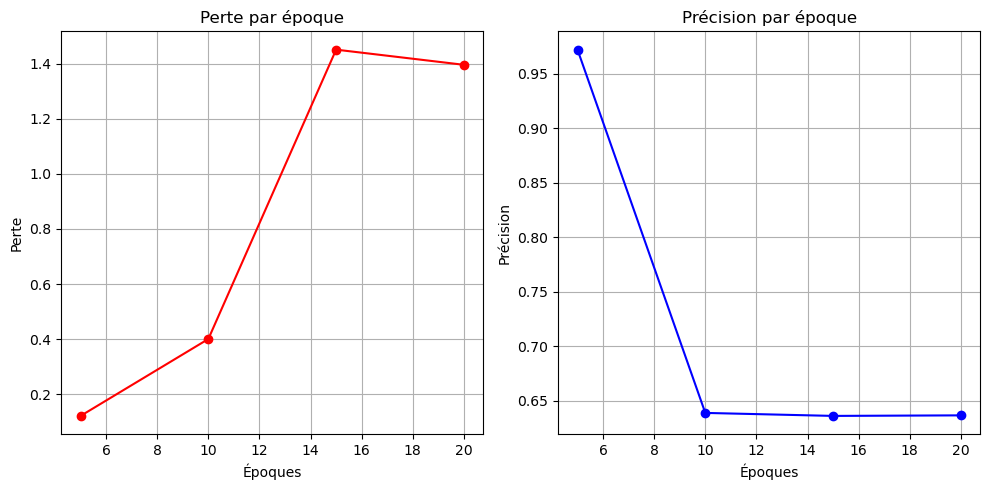

In [21]:
#!pip install matplotlib

import matplotlib.pyplot as plt

# Liste des époques
epochs = list(results.keys())

# Extraire les pertes, les précisions et les temps
losses = [results[epoch]['loss'] for epoch in epoch_list]
accuracies = [results[epoch]['accuracy'] for epoch in epoch_list]
times = [results[epoch]['time'] for epoch in epoch_list]

# Création du graphique
plt.figure(figsize=(10, 5))

# Tracer la courbe de perte
plt.subplot(1, 2, 1)  # 1 ligne, 2 colonnes, premier subplot
plt.plot(epochs, losses, marker='o', color='r')
plt.title('Perte par époque')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.grid(True)

# Tracer la courbe de précision
plt.subplot(1, 2, 2)  # 1 ligne, 2 colonnes, second subplot
plt.plot(epochs, accuracies, marker='o', color='b')
plt.title('Précision par époque')
plt.xlabel('Époques')
plt.ylabel('Précision')
plt.grid(True)

# Afficher le graphique
plt.tight_layout()
plt.show()


Looking at your results, it seems that your model's performance changes significantly with the number of epochs during training. Here are some insights and potential actions based on the data provided:

### Analysis of Results

1. **Epoch 5:**
   - **Test Loss:** 0.121
   - **Test Accuracy:** 97.22%
   - **Time:** 396.03 seconds
   - **Observation:** At 5 epochs, the model performs exceptionally well with a high accuracy and a low loss. This is the best performance among all epochs tested.

2. **Epoch 10:**
   - **Test Loss:** 0.400
   - **Test Accuracy:** 63.87%
   - **Time:** 854.80 seconds
   - **Observation:** Doubling the number of epochs results in a significant drop in performance. This suggests possible overfitting, where the model starts to learn the noise in the training data rather than generalizing from it.

3. **Epoch 15 and 20:**
   - **Test Loss:** Increases to about 1.451 and 1.396 respectively
   - **Test Accuracy:** Stabilizes around 63.6%
   - **Time:** Increases significantly with each increment
   - **Observation:** Further increases in epochs continue to degrade performance, solidifying the notion that the model might be overfitting. Additionally, the training time increases without any gain in model accuracy or decrease in loss.

### Potential Issues and Recommendations

- **Overfitting:** As the number of epochs increases, your model seems to fit too closely to the training data, failing to generalize to new, unseen data (evidenced by increasing test loss and decreasing accuracy).
- **Training Time:** More epochs lead to longer training times without proportional benefits, making the training process inefficient.

### Actions to Consider

1. **Early Stopping:** Implement early stopping during training. This technique will halt the training process once the model's performance stops improving on a held-out validation set.
2. **Model Regularization:** Techniques such as dropout, L2 regularization (weight decay), or others could help prevent overfitting.
3. **Adjust Learning Rate:** Sometimes adjusting the learning rate over time can help manage how the model fits to the data. Consider using learning rate schedules or adaptive learning rate methods like Adam.
4. **Cross-validation:** Use cross-validation to ensure that the model’s performance is robust across different subsets of the dataset.
5. **Experiment with Different Models:** If overfitting continues to be an issue, it might be worthwhile to experiment with simpler models or different architectures that might generalize better.

### Conclusion

Given your results, training the model for fewer epochs (like 5, based on current results) is more advantageous in terms of both accuracy and computational efficiency. Further tuning and the addition of regularization techniques may help improve model stability for higher epochs if needed.

In [22]:
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
import numpy as np

# Define the K-fold Cross Validator
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# K-fold Cross Validation model evaluation
fold_no = 1
losses = []
accuracies = []

for train, test in kfold.split(X_train_tfidf_dense, y_train):

    # Define the model architecture
    model = Sequential()
    model.add(Input(shape=(1, X_train_tfidf_dense.shape[2])))
    model.add(LSTM(64))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    history = model.fit(X_train_tfidf_dense[train], y_train.iloc[train], 
                        epochs=10, 
                        batch_size=32, 
                        verbose=1)

    # Evaluate the model
    scores = model.evaluate(X_train_tfidf_dense[test], y_train.iloc[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    losses.append(scores[0])
    accuracies.append(scores[1])

    fold_no = fold_no + 1

# Print overall results
average_loss = np.mean(losses)
average_accuracy = np.mean(accuracies)
print(f'Average Loss: {average_loss}')
print(f'Average Accuracy: {average_accuracy * 100}%')


------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 40s 96ms/step - accuracy: 0.8598 - loss: 0.5520
Epoch 2/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 63s 159ms/step - accuracy: 0.9564 - loss: 0.1489
Epoch 3/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 68s 171ms/step - accuracy: 0.9735 - loss: 0.0809
Epoch 4/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 67s 168ms/step - accuracy: 0.9817 - loss: 0.0494
Epoch 5/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 43s 108ms/step - accuracy: 0.9926 - loss: 0.0279
Epoch 6/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 80s 102ms/step - accuracy: 0.9957 - loss: 0.0202
Epoch 7/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 41s 101ms/step - accuracy: 0.9962 - loss: 0.0141
Epoch 8/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 41s 102ms/step - accuracy: 0.9974 - loss: 0.0072
Epoch 9/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 40s 98ms/step - accuracy: 0.9968 - loss: 0.0073
Epoch 10/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 38s 95ms/step - accuracy: 0.9987 - loss: 0.0066
Score for fold 